# Procedures

### - Firstly, we start with selecting one trait from the Poplar datasets, because we want to illustrate the general idea of building this model; 
### - Step by step, we read the selected data, prepare the data, build the CNN model and train the model, make prediction, and visualize the results;
### - Then, we move to and work on the whole dataset, which contains 5 traits and 3 p-values. We apply the model to each traits and compare the results of the traits. Results are visualized, too.
### - In addition, we apply another model to the whole dataset and visualize the new results;
### - Comparing the results between two different models;
### - Conlude and discuss.

In [94]:
%matplotlib inline

import random
from time import time
import gzip

from matplotlib import pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Flatten, Reshape, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

# specify a seed for repeating the exactly results
np.random.seed(seed=28213)

# Load data and remove the NAs

##### We use 'Av_Diameter_mm_0.001.geno' and 'pheno_Av_Diameter_mm_0.001' in this example.

In [95]:
# load data
genotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/Av_Diameter_mm_0.001.geno'
genotype = pd.read_csv(genotype_file, sep='\t', index_col=0)
print('genotype_file shape:', genotype.shape)

genotype = genotype[genotype.columns[5:]].T
genotype[genotype == '0/1'] = 0
genotype[genotype == '1/0'] = 0
genotype[genotype == '0/0'] = -1
genotype[genotype == '1/1'] = 1

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (8233, 270)


In [96]:
genotype

CHROM:POS,Chr01:486368,Chr01:584138,Chr01:1158179,Chr01:1426774,Chr01:1483288,Chr01:1683545,Chr01:1893138,Chr01:2075252,Chr01:2461482,Chr01:2471359,...,scaffold_23:735977,scaffold_23:762326,scaffold_23:768691,scaffold_23:769427,scaffold_23:770380,scaffold_23:805493,scaffold_23:806057,scaffold_23:811343,scaffold_23:813240,scaffold_20:910003
BESC-103,0,0,-1,-1,-1,-1,-1,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
BESC-106,-1,1,-1,-1,0,-1,0,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
BESC-107,0,-1,-1,-1,-1,-1,-1,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
BESC-11,0,1,0,-1,-1,-1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
BESC-110,-1,0,-1,-1,0,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WHTE-28-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
WHTE-28-2,0,0,-1,-1,1,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
WHTE-28-3,1,0,-1,-1,1,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
YALD-27-5,0,-1,-1,-1,0,-1,-1,0,-1,0,...,0,1,1,1,1,1,1,1,0,1


In [97]:
# phenotype
phenotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/pheno_Av_Diameter_mm_0.001'
multi_pheno = pd.read_csv(phenotype_file, sep='\t', index_col=0)
print('phenotype_multi shape:', multi_pheno.shape)

phenotype_multi shape: (265, 1)


In [98]:
multi_pheno

,Av_Diameter_mm
ID,
BESC-103,15.420
BESC-106,17.465
BESC-107,7.715
BESC-11,12.645
BESC-110,15.470
...,...
WHTE-28-1,12.075
WHTE-28-2,11.270
WHTE-28-3,12.925


In [99]:
X = genotype
Y = multi_pheno.iloc[:, 0]

# take a small part to test code
# X = genotype.iloc[:, 0:10000]
# Y = multi_pheno.iloc[:, 2]

In [100]:
# move the gene loci with NA traits
X = X[~Y.isna()]
Y = Y[~Y.isna()]

X.shape, Y.shape

((265, 8233), (265,))

# Prepare data 

## One-hot encoding

In [101]:
X_onehot = to_categorical(X)

X_onehot.shape

(265, 8233, 2)

## Split train and test

In [102]:
# split df to train and valid
X_train, X_test, Y_train, Y_test = train_test_split(
    X_onehot, Y, test_size=0.1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((238, 8233, 2), (27, 8233, 2), (238,), (27,))

In [103]:
# split df to train and valid
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, test_size=0.1)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((214, 8233, 2), (24, 8233, 2), (214,), (24,))

In [104]:
Y_train

ID
GW-9578       3.975
KLNC-20-2     5.855
BESC-268     10.790
GW-9907      13.095
GW-9888      14.300
              ...  
FNYI-28-4     8.535
BESC-271     10.915
BESC-309     11.065
HRSP-27-4     9.205
GW-9896      11.250
Name: Av_Diameter_mm, Length: 214, dtype: float64

# Method 

## Build autoencoder model

In [105]:
# hyperparameters
batch_size = 16
learning_rate = 0.0001
epochs = 100

# conv 1D
num_kernels = 16
feature_size = X_train.shape[1]
inChannel = 2
kr = 1e-3
drop_prec = 0.50

In [106]:
classifier = Sequential()

classifier.add(
    Conv1D(
        num_kernels,
        5,
        padding='same',
        activation='relu',
        kernel_regularizer=l1_l2(kr),
        input_shape=(feature_size, inChannel)))
classifier.add(AveragePooling1D(pool_size=2))
classifier.add(Dropout(drop_prec))

classifier.add(Flatten())

classifier.add(Dropout(drop_prec))
classifier.add(Dense(1))

#compile
classifier.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['acc'])

#summary
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 8233, 16)          176       
_________________________________________________________________
average_pooling1d_3 (Average (None, 4116, 16)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4116, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65856)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 65856)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65857     
Total params: 66,033
Trainable params: 66,033
Non-trainable params: 0
__________________________________________________

## Training

In [107]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None
)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    '~/CNN_checkpoint_model.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=14)

In [108]:
classifier_fit = classifier.fit(
    X_train,
    Y_train,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_valid, Y_valid),
    callbacks=[ModelCheckpoint]
)

Epoch 1/100
14/14 [==============================] - 0s 23ms/step - loss: 68.4756 - acc: 0.0000e+00 - val_loss: 11.0060 - val_acc: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 12.8495 - acc: 0.0000e+00 - val_loss: 16.4655 - val_acc: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 11.8259 - acc: 0.0000e+00 - val_loss: 9.6504 - val_acc: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 9.5822 - acc: 0.0000e+00 - val_loss: 8.2655 - val_acc: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 9.3960 - acc: 0.0000e+00 - val_loss: 8.4974 - val_acc: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 13ms/step - loss: 8.8226 - acc: 0.0000e+00 - val_loss: 8.5254 - val_acc: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 8.4250 - acc: 0.0000e+00 - val_loss: 8.1154 - val_acc: 0.0000e+00
Epoch 8/100
14/

Epoch 28/100
14/14 [==============================] - 0s 13ms/step - loss: 1.4465 - acc: 0.0000e+00 - val_loss: 2.3171 - val_acc: 0.0000e+00
Epoch 29/100
14/14 [==============================] - 0s 14ms/step - loss: 1.3679 - acc: 0.0000e+00 - val_loss: 2.0734 - val_acc: 0.0000e+00
Epoch 30/100
14/14 [==============================] - 0s 13ms/step - loss: 1.5780 - acc: 0.0000e+00 - val_loss: 2.0572 - val_acc: 0.0000e+00
Epoch 31/100
14/14 [==============================] - 0s 13ms/step - loss: 1.3750 - acc: 0.0000e+00 - val_loss: 1.9883 - val_acc: 0.0000e+00
Epoch 32/100
14/14 [==============================] - 0s 14ms/step - loss: 1.1630 - acc: 0.0000e+00 - val_loss: 1.9447 - val_acc: 0.0000e+00
Epoch 33/100
14/14 [==============================] - 0s 13ms/step - loss: 1.0346 - acc: 0.0000e+00 - val_loss: 1.8151 - val_acc: 0.0000e+00
Epoch 34/100
14/14 [==============================] - 0s 13ms/step - loss: 1.1948 - acc: 0.0000e+00 - val_loss: 1.7459 - val_acc: 0.0000e+00
Epoch 35/100


Epoch 55/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6487 - acc: 0.0000e+00 - val_loss: 1.4524 - val_acc: 0.0000e+00
Epoch 56/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5356 - acc: 0.0000e+00 - val_loss: 1.4220 - val_acc: 0.0000e+00
Epoch 57/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5391 - acc: 0.0000e+00 - val_loss: 1.4265 - val_acc: 0.0000e+00
Epoch 58/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5692 - acc: 0.0000e+00 - val_loss: 1.3954 - val_acc: 0.0000e+00
Epoch 59/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5698 - acc: 0.0000e+00 - val_loss: 1.5011 - val_acc: 0.0000e+00
Epoch 60/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5257 - acc: 0.0000e+00 - val_loss: 1.4190 - val_acc: 0.0000e+00
Epoch 61/100
14/14 [==============================] - 0s 13ms/step - loss: 0.5338 - acc: 0.0000e+00 - val_loss: 1.4962 - val_acc: 0.0000e+00
Epoch 62/100


Epoch 82/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4320 - acc: 0.0000e+00 - val_loss: 1.3974 - val_acc: 0.0000e+00
Epoch 83/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4206 - acc: 0.0000e+00 - val_loss: 1.4041 - val_acc: 0.0000e+00
Epoch 84/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4429 - acc: 0.0000e+00 - val_loss: 1.4272 - val_acc: 0.0000e+00
Epoch 85/100
14/14 [==============================] - 0s 14ms/step - loss: 0.4282 - acc: 0.0000e+00 - val_loss: 1.4242 - val_acc: 0.0000e+00
Epoch 86/100
14/14 [==============================] - 0s 13ms/step - loss: 0.4750 - acc: 0.0000e+00 - val_loss: 1.4375 - val_acc: 0.0000e+00
Epoch 87/100
14/14 [==============================] - 0s 14ms/step - loss: 0.4157 - acc: 0.0000e+00 - val_loss: 1.5028 - val_acc: 0.0000e+00
Epoch 88/100
14/14 [==============================] - 0s 14ms/step - loss: 0.4840 - acc: 0.0000e+00 - val_loss: 1.5219 - val_acc: 0.0000e+00
Epoch 89/100


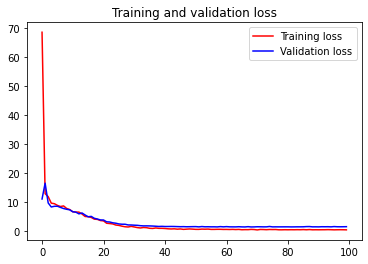

In [109]:
# plot loss curve on validation data
loss = classifier_fit.history['loss']
val_loss = classifier_fit.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'r', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

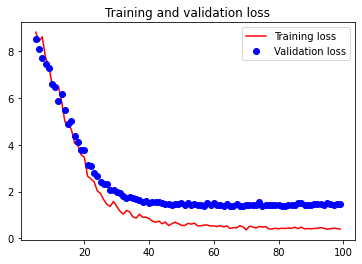

In [110]:
#due to the beginning loss too large,we plot again starting from index 5 epoch.
# plot loss curve on validation data
loss = classifier_fit.history['loss']
val_loss = classifier_fit.history['val_loss']

plt.figure()
plt.plot(range(5,len(loss)), loss[5:], 'r', label='Training loss')
plt.plot(range(5,len(val_loss)), val_loss[5:], 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction

In [111]:
# predict
Y_predict = classifier.predict_proba(X_test)

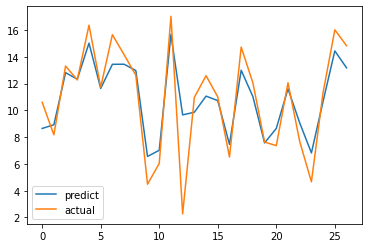

In [112]:
plt.plot(np.arange(len(Y_predict)),Y_predict,label = 'predict')
plt.plot(np.arange(len(Y_predict)),np.array(Y_test),label = 'actual')
plt.legend()
plt.show()

Mean Square Error (MSE) = 3.5757928536870858
Correlation R^2 = 0.46241593184857754


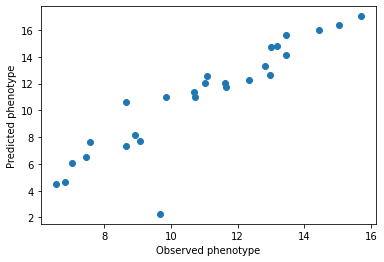

In [113]:
plt.xlabel('Observed phenotype')
plt.ylabel('Predicted phenotype')
plt.scatter(Y_predict,Y_test)
print(f"Mean Square Error (MSE) = {mean_squared_error(Y_predict, Y_test)}")
print(f"Correlation R^2 = {r2_score(Y_predict, Y_test)}")

### We could find that the prediction and the actual result almostly coincide. Moreover, the actual result is somewhat more radical than the prediction, which challenges us to predict.

# Make comparisons among different geno datasets

In [ ]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]
loss_list = []
for threshold in thresholds:
    for trait in traits:
        print("threshold is",threshold,";trait is",trait,"\n");
        filename_geno = trait + "_" + threshold + ".geno"
        filename_pheno = "pheno_" + trait + "_" + threshold

        # load data
        genotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_geno
        genotype = pd.read_csv(genotype_file, sep='\t', index_col=0)
        print('genotype_file shape:', genotype.shape)

        genotype = genotype[genotype.columns[5:]].T
        genotype[genotype == '0/1'] = 0
        genotype[genotype == '1/0'] = 0
        genotype[genotype == '0/0'] = -1
        genotype[genotype == '1/1'] = 1

        # phenotype
        phenotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_pheno
        multi_pheno = pd.read_csv(phenotype_file, sep='\t', index_col=0)
        print('phenotype_multi shape:', multi_pheno.shape)

        X = genotype
        Y = multi_pheno.iloc[:, 0]

        # move the gene loci with NA traits
        X = X[~Y.isna()]
        Y = Y[~Y.isna()]

        if X.shape[0] != Y.shape[0]:
            print('Inconsistent data')

        X_onehot = to_categorical(X)

        X_onehot.shape

        # split df to train and valid
        X_train, X_test, Y_train, Y_test = train_test_split(
            X_onehot, Y, test_size=0.1)

        X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

        # split df to train and valid
        X_train, X_valid, Y_train, Y_valid = train_test_split(
            X_train, Y_train, test_size=0.1)

        X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

        # hyperparameters
        batch_size = 16
        learning_rate = 0.0001
        epochs = 100

        # conv 1D
        num_kernels = 16
        feature_size = X_train.shape[1]
        inChannel = 2
        kr = 1e-3
        drop_prec = 0.50

        classifier = Sequential()

        classifier.add(
            Conv1D(
                num_kernels,
                5,
                padding='same',
                activation='relu',
                kernel_regularizer=l1_l2(kr),
                input_shape=(feature_size, inChannel)))
        classifier.add(AveragePooling1D(pool_size=2))
        classifier.add(Dropout(drop_prec))

        classifier.add(Flatten())

        classifier.add(Dropout(drop_prec))
        classifier.add(Dense(1))

        #compile
        classifier.compile(
            loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(learning_rate),
            metrics=['acc'])

        #summary
        classifier.summary()
        
        classifier_fit = classifier.fit(
            X_train,
            Y_train,
            shuffle=True,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_valid, Y_valid),
            callbacks=[ModelCheckpoint]
        )
        val_loss = classifier_fit.history['val_loss']
        loss_list.append(val_loss[-1])

# Other Methods

## Random Forests Regression

In [25]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]
loss_list2 = []
for threshold in thresholds:
    for trait in traits:

        print("threshold is",threshold,";trait is",trait,"\n");
        filename_geno = trait + "_" + threshold + ".geno"
        filename_pheno = "pheno_" + trait + "_" + threshold

        # load data
        genotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_geno
        genotype = pd.read_csv(genotype_file, sep='\t', index_col=0)
        print('genotype_file shape:', genotype.shape)

        genotype = genotype[genotype.columns[5:]].T
        genotype[genotype == '0/1'] = 0
        genotype[genotype == '1/0'] = 0
        genotype[genotype == '0/0'] = -1
        genotype[genotype == '1/1'] = 1

        # phenotype
        phenotype_file = '~/Poplar_GWAS/GS_method_compare/GS_geno_pheno/' + filename_pheno
        multi_pheno = pd.read_csv(phenotype_file, sep='\t', index_col=0)
        print('phenotype_multi shape:', multi_pheno.shape)

        X = genotype
        Y = multi_pheno.iloc[:, 0]

        # move the gene loci with NA traits
        X = X[~Y.isna()]
        Y = Y[~Y.isna()]

        if X.shape[0] != Y.shape[0]:
            print('Inconsistent data')

        # split df to train and valid
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.1)




        # split df to train and valid
        X_train, X_valid, Y_train, Y_valid = train_test_split(
            X_train, Y_train, test_size=0.1)


        from sklearn.ensemble import RandomForestRegressor

        regressor = RandomForestRegressor()

        regressor.fit(X_train,Y_train)

        y_pred = regressor.predict(X_test)

        mse2 = tf.losses.mean_squared_error(y_pred, Y_test)
        print(mse2)
        
        loss_list2.append(float(mse2))

threshold is 1e-05 ;trait is Jmax25 

genotype_file shape: (234, 271)
phenotype_multi shape: (266, 1)
tf.Tensor(1265.019481424586, shape=(), dtype=float64)
threshold is 1e-05 ;trait is Rdlight25 

genotype_file shape: (186, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(0.6471166218762635, shape=(), dtype=float64)
threshold is 1e-05 ;trait is Resistwp25 

genotype_file shape: (377, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(10.752663113054608, shape=(), dtype=float64)
threshold is 1e-05 ;trait is WUEref 

genotype_file shape: (490, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(5.858297163449207, shape=(), dtype=float64)
threshold is 1e-05 ;trait is Av_Diameter_mm 

genotype_file shape: (72, 270)
phenotype_multi shape: (265, 1)
tf.Tensor(7.555911964351848, shape=(), dtype=float64)
threshold is 1e-04 ;trait is Jmax25 

genotype_file shape: (1380, 271)
phenotype_multi shape: (266, 1)
tf.Tensor(618.8698867497574, shape=(), dtype=float64)
threshold is 1e-04 ;trait is Rdlight25 

genoty

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


phenotype_multi shape: (268, 1)
tf.Tensor(11.021105669512274, shape=(), dtype=float64)
threshold is 1e-04 ;trait is Av_Diameter_mm 

genotype_file shape: (778, 270)
phenotype_multi shape: (265, 1)
tf.Tensor(4.194995726481484, shape=(), dtype=float64)
threshold is 0.001 ;trait is Jmax25 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (9973, 271)
phenotype_multi shape: (266, 1)
tf.Tensor(716.2913547194104, shape=(), dtype=float64)
threshold is 0.001 ;trait is Rdlight25 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (9005, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(0.54401621341993, shape=(), dtype=float64)
threshold is 0.001 ;trait is Resistwp25 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (11630, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(8.875966932231403, shape=(), dtype=float64)
threshold is 0.001 ;trait is WUEref 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (27861, 273)
phenotype_multi shape: (268, 1)
tf.Tensor(11.272750202580406, shape=(), dtype=float64)
threshold is 0.001 ;trait is Av_Diameter_mm 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


genotype_file shape: (8233, 270)
phenotype_multi shape: (265, 1)
tf.Tensor(5.250725976759258, shape=(), dtype=float64)


# Visualization

### comparing the CNN model with RF under fixed p-values.

In [22]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.rc("font", family="DejaVu Sans", size="15")

In [23]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]

data = pd.DataFrame()
data['loss'] = loss_list
data['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data['traits'] = 3 * traits
data['method'] = 'CNN'

data2 = pd.DataFrame()
data2['loss'] = loss_list2
data2['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data2['traits'] = 3 * traits
data2['method'] = 'RF'
data = pd.concat([data,data2])

data = data[data['traits'] != 'Jmax25']

### Here, in order to make the visualization work, go back to the previous cells to compile functions "loss_list" and "loss_list2" one more time.

In [26]:
thresholds = ['1e-05','1e-04','0.001']
traits = ["Jmax25","Rdlight25","Resistwp25","WUEref","Av_Diameter_mm"]

data3 = pd.DataFrame()
data3['loss'] = loss_list
data3['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data3['traits'] = 3 * traits
data3['method'] = 'CNN'

data4 = pd.DataFrame()
data4['loss'] = loss_list2
data4['thresholds'] =[thresholds[0]]*5 + [thresholds[1]]*5 + [thresholds[2]]*5
data4['traits'] = 3 * traits
data4['method'] = 'RF'
data3 = pd.concat([data3,data4])

data3 = data3[data3['traits'] != 'Jmax25']

In [27]:
data = pd.concat([data,data3])

<AxesSubplot:xlabel='traits', ylabel='loss'>

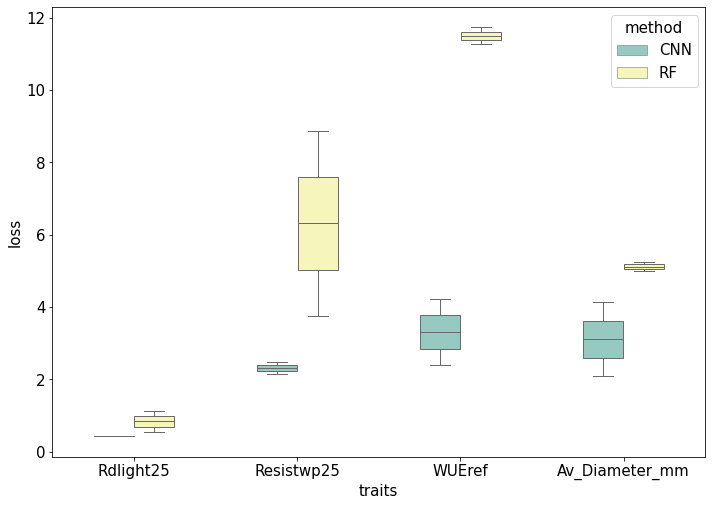

In [28]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
data_tmp1 = data[data['thresholds'] == '0.001']
sns.boxplot(x="traits", y="loss", data=data_tmp1, hue="method", width=0.5, linewidth=1.0, palette="Set3") 
#sns.boxplot(x="thresholds", y="loss", data=data, hue="traits", width=0.5, linewidth=1.0, palette="Set3") 

### Model's effect on "Jmax25" is considerably poor, thus this specific trait is not displayed on the graph.

<AxesSubplot:xlabel='traits', ylabel='loss'>

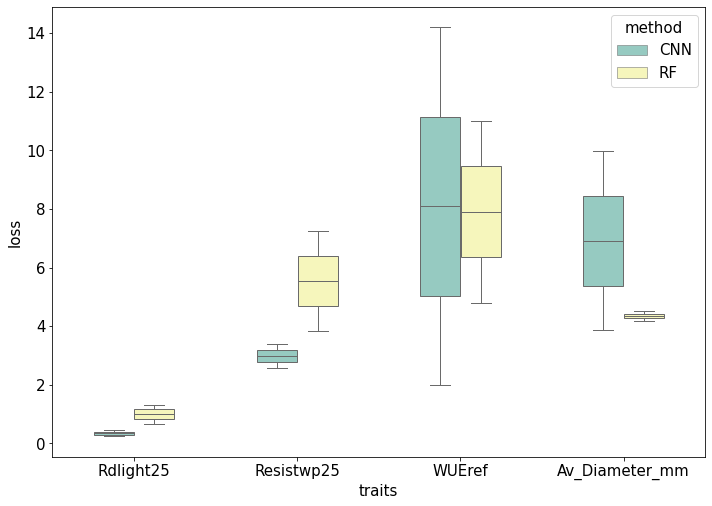

In [29]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
data_tmp1 = data[data['thresholds'] == '1e-04']
sns.boxplot(x="traits", y="loss", data=data_tmp1, hue="method", width=0.5, linewidth=1.0, palette="Set3") 
#sns.boxplot(x="thresholds", y="loss", data=data, hue="traits", width=0.5, linewidth=1.0, palette="Set3") 

<AxesSubplot:xlabel='traits', ylabel='loss'>

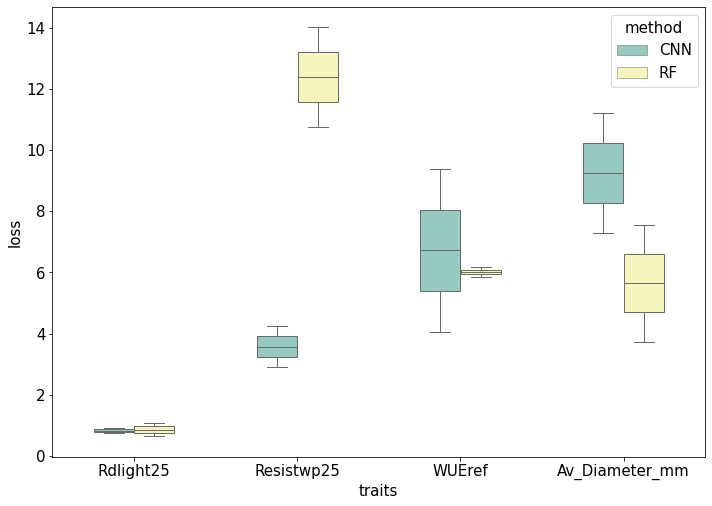

In [30]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
data_tmp1 = data[data['thresholds'] == '1e-05']
sns.boxplot(x="traits", y="loss", data=data_tmp1, hue="method", width=0.5, linewidth=1.0, palette="Set3") 
#sns.boxplot(x="thresholds", y="loss", data=data, hue="traits", width=0.5, linewidth=1.0, palette="Set3") 

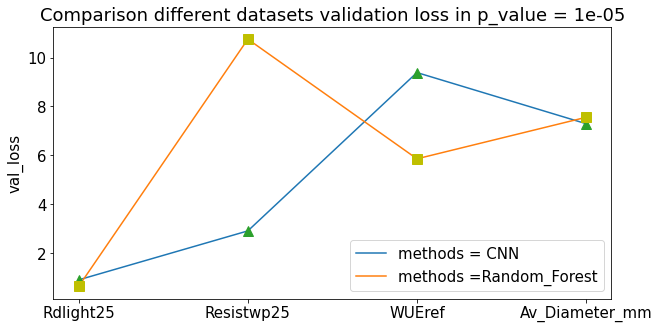

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(traits[1:],loss_list[1:5],label = 'methods = CNN')
plt.plot(traits[1:],loss_list2[1:5],label = 'methods =Random_Forest')
plt.plot(traits[1:],loss_list[1:5],'^',markersize = 10)
plt.plot(traits[1:],loss_list2[1:5],'sy',markersize = 10)
plt.ylabel('val_loss',fontsize = 15)
plt.title('Comparison different datasets validation loss in p_value = 1e-05',fontsize = 18)
plt.legend()
plt.show()

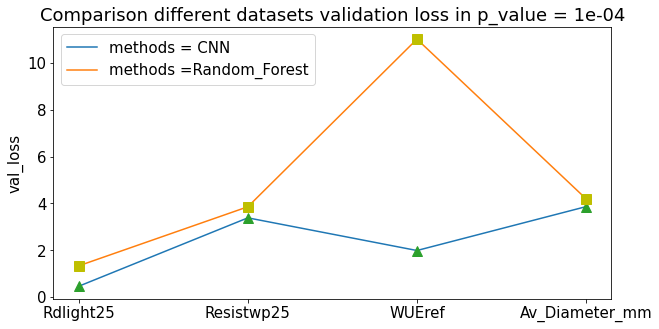

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(traits[1:],loss_list[6:10],label = 'methods = CNN')
plt.plot(traits[1:],loss_list2[6:10],label = 'methods =Random_Forest')
plt.plot(traits[1:],loss_list[6:10],'^',markersize = 10)
plt.plot(traits[1:],loss_list2[6:10],'sy',markersize = 10)
plt.ylabel('val_loss',fontsize = 15)
plt.title('Comparison different datasets validation loss in p_value = 1e-04',fontsize = 18)
plt.legend()
plt.show()

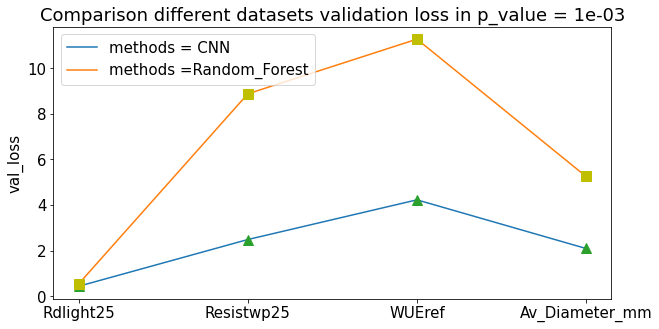

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(traits[1:],loss_list[11:15],label = 'methods = CNN')
plt.plot(traits[1:],loss_list2[11:15],label = 'methods =Random_Forest')
plt.plot(traits[1:],loss_list[11:15],'^',markersize = 10)
plt.plot(traits[1:],loss_list2[11:15],'sy',markersize = 10)
plt.ylabel('val_loss',fontsize = 15)
plt.title('Comparison different datasets validation loss in p_value = 1e-03',fontsize = 18)
plt.legend()
plt.show()

## Below lists some unused visualization. It compares different datasets validation loss in CNN under different p-values.

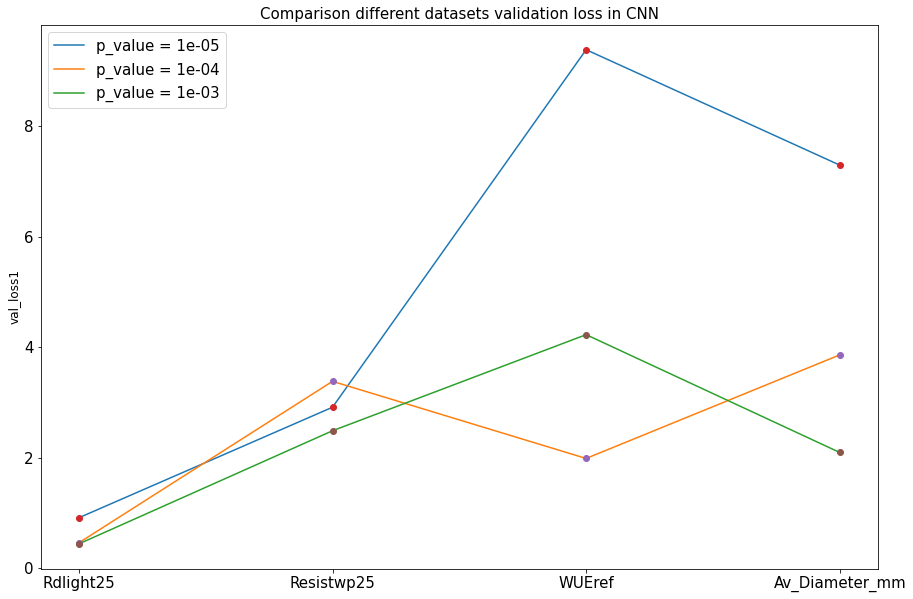

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(traits[1:],loss_list[1:5],label = 'p_value = 1e-05')
plt.plot(traits[1:],loss_list[6:10],label = 'p_value = 1e-04')
plt.plot(traits[1:],loss_list[11:15],label = 'p_value = 1e-03')
plt.plot(traits[1:],loss_list[1:5],'o')
plt.plot(traits[1:],loss_list[6:10],'o')
plt.plot(traits[1:],loss_list[11:15],'o')
plt.ylabel('val_loss1',fontsize = 12)
plt.title('Comparison different datasets validation loss in CNN',fontsize = 15)
plt.legend()
plt.show()

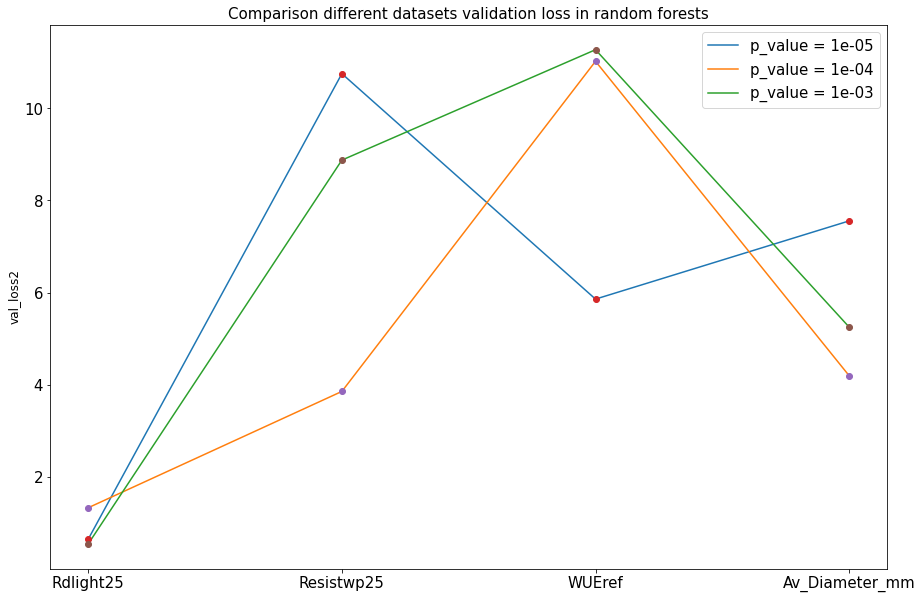

In [35]:
plt.figure(figsize=(15, 10))
plt.plot(traits[1:],loss_list2[1:5],label = 'p_value = 1e-05')
plt.plot(traits[1:],loss_list2[6:10],label = 'p_value = 1e-04')
plt.plot(traits[1:],loss_list2[11:15],label = 'p_value = 1e-03')
plt.plot(traits[1:],loss_list2[1:5],'o')
plt.plot(traits[1:],loss_list2[6:10],'o')
plt.plot(traits[1:],loss_list2[11:15],'o')
plt.ylabel('val_loss2',fontsize = 12)
plt.title('Comparison different datasets validation loss in random forests',fontsize = 15)
plt.legend()
plt.show()

# Conclusions

### 1. The performance on 'Rdilight25' datasets is competently well overall;
### 2. The smaller the p-value, the stronger stability of the model, and the better the relative comprehensive performance.

# Discussions

### 1. The possible reason for the limitation of the model is that the dataset is not sufficiently large. Theoretically speaking, the model will perform better on a large dataset.
### 2. Models like Linear Regression could also be applied to this problem.